In [1]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
from torch import nn

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper


[INFO] Installing the torchmetrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.8 MB/s eta 0:00:00
[INFO] Installing the torchinfo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[INFO] Downloading the helper function from github


In [2]:
## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Network Setup

## Conv + Relu

In [4]:
class BasicConv2d(nn.Module):
    def __init__(self,out_channels,**kwargs) -> None:
        super().__init__()
        self.bc = nn.Sequential(
            nn.LazyConv2d(out_channels,**kwargs),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.bc(x)

## Auxillary Classifier Class

In [5]:
class InceptionAux(nn.Module):
    def __init__(self,num_classes) -> None:
        super().__init__()
        self.aux = nn.Sequential(
            nn.AvgPool2d(kernel_size=5,stride=2),
            nn.LazyConv2d(128,kernel_size=1,stride=1,padding=0),
            nn.Flatten(),
            nn.Dropout2d(0.5),
            nn.LazyLinear(1024),            
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            nn.Linear(1024,num_classes)
            
        )
    def forward(self,x):
        return self.aux(x)

## Inception Structure

In [6]:
class Inception(nn.Module):
    def __init__(self,ch1x1,ch3x3red,ch3x3,ch5x5red,ch5x5,pool_proj) -> None:
        super().__init__()
        
        self.branch1 = BasicConv2d(ch1x1,kernel_size=1,stride=1,padding=0)
        
        self.branch2 = nn.Sequential(
            BasicConv2d(ch3x3red,kernel_size=1,stride=1,padding=0),
            BasicConv2d(ch3x3,kernel_size=3,stride=1,padding=1)
        )
        
        self.branch3 = nn.Sequential(
            BasicConv2d(ch5x5red,kernel_size=1,stride=1,padding=0),
            BasicConv2d(ch5x5,kernel_size=5,stride=1,padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            BasicConv2d(pool_proj,kernel_size=1,stride=1,padding=0)
        )
        
    def forward(self,x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        
        return torch.cat((b1,b2,b3,b4),dim=1)

## GoogLeNet

In [40]:
class GoogLeNet(helper.Classifier):
    def __init__(self,lr=0.01,num_classes=10) -> None:
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        
        self.main = nn.Sequential(
            BasicConv2d(64,kernel_size=7,stride=2,padding=3),
            nn.MaxPool2d(kernel_size=3,stride=2,ceil_mode=True),
            
            BasicConv2d(64,kernel_size=1,stride=1,padding=0),
            BasicConv2d(192,kernel_size=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=3,stride=2,ceil_mode=True),
            
            Inception(64,96,128,16,32,32),
            Inception(128,128,192,32,96,64),
            nn.MaxPool2d(kernel_size=3,stride=2,ceil_mode=True),
            Inception(192,96,208,16,48,64)
        )
        
        self.main2 = nn.Sequential(
            Inception(160, 112, 224, 24, 64, 64),
            Inception(128, 128, 256, 24, 64, 64),
            Inception(112, 144, 288, 32, 64, 64),
        )
        
        self.main3 = nn.Sequential(
            Inception(256,160,320,32,128,128),
            nn.MaxPool2d(kernel_size=3,stride=2,ceil_mode=True),
            Inception(256, 160, 320, 32, 128, 128),
            Inception(384, 192, 384, 48, 128, 128),
            
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.LazyLinear(num_classes)
        )
        
        self.aux1 = InceptionAux(num_classes)
        self.aux2 = InceptionAux(num_classes)
        
        
    def forward(self, x: torch.Tensor):
        x = self.main(x)
        aux1 = self.aux1(x)
        x = self.main2(x)
        aux2 = self.aux2(x)
        x = self.main3(x)
        
        return x,aux1,aux2
    
    def apply_initialize_weight(self,inputs):
        self.forward(*inputs)
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode="fan_out",nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,0,0.01)
                nn.init.constant_(m.bias,0)
                
        
    def training_step(self, batch: List):
        X,y = batch
        
        # compute the loss at main ,aux1,aux2
        y_logits,aux1,aux2 = self(X)
        loss0 = self.loss(y_logits,y)
        loss1 = self.loss(aux1,y)
        loss2 = self.loss(aux2,y)
        # print(loss0.item(),loss1.item(),loss2.item())
        
        loss = loss0 + 0.3 * loss1 + 0.3 * loss2
        acc = self.accuracy(y_logits,y)
        return dict(loss=loss,acc=acc)   
    
    def validation_step(self, batch: List):
        X,y = batch
        
        # forward pass 
        y_logits,aux1,aux2 = self(X)
        
        loss = self.loss(y_logits,y)
        acc = self.accuracy(y_logits,y)
        return dict(loss=loss,acc=acc)

# Summary

In [41]:
torchinfo.summary(GoogLeNet(),input_size=(1,1,224,224)  ,  col_width=14,depth=2,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

Layer (type (var_name))                       Kernel Shape   Output Shape   Param #        Mult-Adds
GoogLeNet (GoogLeNet)                         --             [1, 10]        --             --
├─Sequential (main)                           --             [1, 512, 14, 14] --             --
│    └─BasicConv2d (0)                        --             [1, 64, 112, 112] 3,200          40,140,800
│    └─MaxPool2d (1)                          3              [1, 64, 56, 56] --             --
│    └─BasicConv2d (2)                        --             [1, 64, 56, 56] 4,160          13,045,760
│    └─BasicConv2d (3)                        --             [1, 192, 56, 56] 110,784        347,418,624
│    └─MaxPool2d (4)                          3              [1, 192, 28, 28] --             --
│    └─Inception (5)                          --             [1, 256, 28, 28] 163,696        128,337,664
│    └─Inception (6)                          --             [1, 480, 28, 28] 388,736        304,769

# Training the model

In [42]:
data = helper.FashionMNIST(batch_size=64,resize=(224,224))
model = GoogLeNet(num_classes=10,lr=0.001)

In [43]:
model.apply_initialize_weight([next(iter(data.train_dataloader()))[0]])

In [44]:
trainer = helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH,verbose=True)

Training the model in cuda


[INFO] Entering FIT
[INFO] Entering Data Preparation
[INFO] Entering Model Preparation
[INFO] Entering Plot Preparation


  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Start Fitting per epoch
	Batch 0 - Training Loss 12.649665832519531
	Batch 187 - Training Loss 3.692282199859619
	Batch 374 - Training Loss 3.433600902557373
	Batch 561 - Training Loss 3.5823841094970703
	Batch 748 - Training Loss 3.602003574371338
	Batch 935 - Training Loss 3.3013968467712402
	Batch 0 - Validation Loss 1.9067912101745605
At end 0 Epoch - Training Loss 3.4895102977752686|                         Training Loss 1.9686096906661987
[INFO] Start Fitting per epoch
	Batch 0 - Training Loss 3.2469820976257324
	Batch 187 - Training Loss 3.4276158809661865
	Batch 374 - Training Loss 3.1577367782592773
	Batch 561 - Training Loss 2.9849417209625244
	Batch 748 - Training Loss 2.8936288356781006
	Batch 935 - Training Loss 2.742616653442383
	Batch 0 - Validation Loss 1.272193431854248
At end 1 Epoch - Training Loss 3.0407402515411377|                         Training Loss 1.3201550245285034
[INFO] Start Fitting per epoch
	Batch 0 - Training Loss 2.8694965839385986
	Batch 187 -

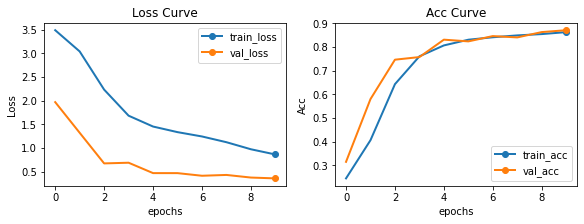

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-06/GoogLeNet-194110.pth


In [45]:
trainer.fit(model,data)